# Convolutional Autoencoder

## Part 1 - Creating a Convolutional Autoencoder to reconstruct MNIST dataset

### Loading packages

In [53]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

### Loading the MNIST dataset

In [54]:
from keras.datasets import mnist #importing the MNIST dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
print("trainX shape = ", trainX.shape, "trainY shape = ", trainY.shape)
print("testX shape  = ", testX.shape, "testY shape  = ", testY.shape)

trainX shape =  (60000, 28, 28) trainY shape =  (60000,)
testX shape  =  (10000, 28, 28) testY shape  =  (10000,)


### Casting inputs to float32

In [55]:
trainX = trainX.astype('float32')
testX  = testX.astype('float32')
print("trainX shape = ", trainX.shape, "trainY shape = ", trainY.shape)
print("testX shape  = ", testX.shape, "testY shape  = ", testY.shape)

trainX shape =  (60000, 28, 28) trainY shape =  (60000,)
testX shape  =  (10000, 28, 28) testY shape  =  (10000,)


### Normalizing the inputs

In [56]:
trainX /= 255.0
testX  /= 255.0

### Constructing the Convolutional Autoencoder class

In [57]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16):
        #Encorder
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs
        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        encoder = Model(inputs, latent, name="encoder")
        
        #Decorder
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        decoder = Model(latentInputs, outputs, name="decoder")
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
        return (encoder, decoder, autoencoder)

### Setting hyperparameters 

In [58]:
EPOCHS = 50 #No of epochs
INIT_LR = 1e-3 #Initial learning rate
BS = 256 #Batch size

### Adding a channel dimension to each pixel 

In [59]:
trainX = np.expand_dims(trainX, axis=-1)
testX  = np.expand_dims(testX,  axis=-1)

### Building the Convolutional Autoencoder model 

In [60]:
(encoder, decoder, autoencoder) = ConvAutoencoder().build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 16)                69392     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
______________________________

### Fitting the Convolutional Autoencoder 

In [61]:
hist = autoencoder.fit(trainX, trainX, epochs=EPOCHS, batch_size=BS, validation_data=(testX, testX), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 36s 605us/sample - loss: 0.0459 - val_loss: 0.0366
Epoch 2/50
60000/60000 [==============================] - 39s 645us/sample - loss: 0.0146 - val_loss: 0.0125
Epoch 3/50
60000/60000 [==============================] - 37s 609us/sample - loss: 0.0119 - val_loss: 0.0108
Epoch 4/50
60000/60000 [==============================] - 37s 620us/sample - loss: 0.0106 - val_loss: 0.0106
Epoch 5/50
60000/60000 [==============================] - 38s 641us/sample - loss: 0.0099 - val_loss: 0.0096
Epoch 6/50
60000/60000 [==============================] - 38s 632us/sample - loss: 0.0094 - val_loss: 0.0094
Epoch 7/50
60000/60000 [==============================] - 38s 632us/sample - loss: 0.0090 - val_loss: 0.0089
Epoch 8/50
60000/60000 [==============================] - 39s 654us/sample - loss: 0.0088 - val_loss: 0.0088
Epoch 9/50
60000/60000 [==============================] - 39s 647us/sample - l

### Plotting the model performances 

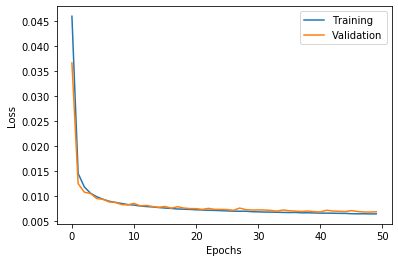

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.show()

plot_history(hist)# use Matplotlib (don't ask)

### Reconstructing the test dataset 

In [70]:
import numpy as np

reconstructed_imgs = autoencoder.predict(testX)

print("Before removing the channel:")
print("Shape of testX                = ", testX.shape)
print("Shape of reconstructed images = ", reconstructed_imgs.shape)

original_imgs = np.squeeze(testX) #After removing the channel
reconstructed_imgs = np.squeeze(reconstructed_imgs) #After removing the channel

print("After removing the channel:")
print("Shape of original images      = ", original_imgs.shape)
print("Shape of reconstructed images = ", reconstructed_imgs.shape)

Before removing the channel:
Shape of testX                =  (10000, 28, 28, 1)
Shape of reconstructed images =  (10000, 28, 28, 1)
After removing the channel:
Shape of original images      =  (10000, 28, 28)
Shape of reconstructed images =  (10000, 28, 28)


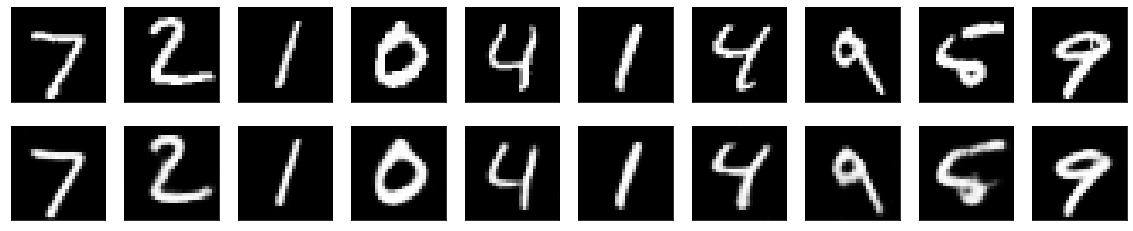

In [71]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Part 2 - Convolutional Autoencoder reconstructng a different image dataset 

### Loading the FASHION_MNIST dataset (Different from the MNIST dataset, but they are of same size (28*28)) 

In [73]:
from keras.datasets import fashion_mnist
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
print(x_train_fashion.shape)
print(y_train_fashion.shape)

4423680/4422102 [==============================] - 33s 8us/step
(60000, 28, 28)
(60000,)


   ### Preparing the test dataset of FASHION_MNIST

In [76]:
x_test_fashion  = x_test_fashion.astype('float32')
print(x_test_fashion.shape)
x_test_fashion  = np.expand_dims(x_test_fashion,  axis=-1)
print(x_test_fashion.shape)

(10000, 28, 28)
(10000, 28, 28, 1)


In [77]:
x_test_fashion /= 255

### Reconstructing FASHION_MNIST test dataset

In [79]:
reconstructed_fashion_imgs = autoencoder.predict(x_test_fashion)
print(reconstructed_fashion_imgs.shape)

(10000, 28, 28, 1)


### Removing channel 

In [84]:
reconstructed_fashion_imgs = np.squeeze(reconstructed_fashion_imgs)
print(reconstructed_fashion_imgs.shape)
x_test_fashion = np.squeeze(x_test_fashion)
print(x_test_fashion.shape)

(10000, 28, 28)
(10000, 28, 28)


### Plotting the first 10 original and reconstructed images

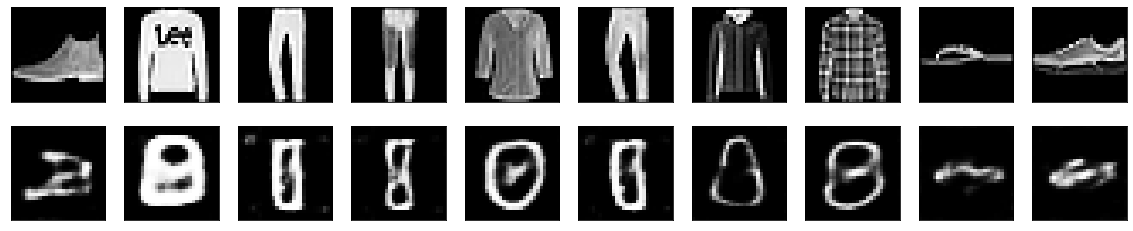

In [85]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_fashion[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_fashion_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()